# Modeling language with Bigrams

The idea is to understand and experiment with the basics of deep neural networs and language modeling using the paper "[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)" as a base to work off of while using the [Wikitext 2 Raw](https://wikitext.smerity.com/wikitext-2-raw-v1.zip) dataset. Core concepts I wish to explore here:
- Mathematic formalization of the problem of language modeling to arrive at an optimization problem.
- The effects of initialization model parameters and training
- The training loop itself, overfitting and some techniques to prevent it


## Rationale

We have a text corpus $T$ of length $n$ characters, from this corpus we derive a dataset $X$ composed of all contiguous bigrams $[x_{i}, x_{i+1}]$ where $i \in 1,\dots,n-1$ (therefore $|X| = n-1$) and $x_{i} \in V$, where $V$ is the set of all characters in $T$ and we say that $|V|=m$. For any character $x_{i}$ the corpus $T$ encodes an underlying, true probability distribution for $x_{i+1}$ :
$$
P(x_{i+1}|x_{i})
$$
Our objective is to approximate that distribution as best we can by using a model composed of parameters $\Theta$ learned from our dataset $X$. The model will use character $x_{i}$ to predict $x_{i+1}$ ideally we would get:
$$
P(x_{i+1}|x_{i}) \approx P(x_{i+1}|x_{i}, \Theta)\in \mathbb{R}^{m}
$$
More practically, we can say that our model is actually a function $f_{\Theta}$ (parameterized by $\Theta$) where:
$$
\text{softmax}(f_{\Theta}(x_{i})) = P(x_{i+1}|x_{i},\Theta)
$$
Where softmax is used to turn our final $m$ logits into a valid probability distribution.

Now, this is an optimization problem. To be precise, we want to minimize the difference between the real distribution and the distribution we're estimating with out model $f_{\Theta}$. For this, we can pull from the idea of cross-entropy which is the measure that we need:
$$
H(p,q)=-\sum p(x)\log q(x)
$$
Applying it to our problem we would get a specific number for the cross-entropy between the relevant distribution this will be our loss and it will be what we want to minimize:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} P(x_{i+1}|x_{i})\log P(x_{i+1}|x_{i},\Theta)
$$
Obviously, we don't have $P(x_{i+1}|x_{i})$, if we did then problem solved we could just use that, instead all we have is our dataset $X$ which tells us a lot about the real distribution for any one *specific* example.

We have all possible bigrams, therefore for any character $x_{i}$ we know what $x_{i+1}$ actually is, therefore we can greatly simplify the problem that assuming that the real distribution $P(x|x_{i})$ has a spike of probability $1$ when $x=x_{i+1}$ and a total of $0$ probability mass when $x=c$, $c$ being any character other than $x_{i+1}$. In formal terms:
$$
P(x|x_{i}) = \begin{cases}
1  &  \text{if} &  x=x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
Since we're conditioning our model probability distribution on predicting $x_{i+1}$ we can say that $P(x_{i+1}|x_{i})=1$ and therefore the loss we have to minimize is:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} \log P(x_{i+1}|x_{i},\Theta)
$$
In practice and mostly for computational reasons we instead calculate the loss over mini batches $B$ where $B \subset X$ (a random selection of training examples), therefore the loss we will actually use is:
$$
\mathcal{L} = -\frac{1}{|B|} \sum_{i \in B} \log (\text{softmax} (f_{\Theta}(x_{i}) )_{y_{i}})
$$
Minimizing this loss amounts to maximizing the probability of seeing the index $y_{i}$ (correct next character according to our data) when out model takes in the character $x_{i}$

### Extracting the data from the corpus

In [2]:
def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

train_raw = "./wikitext-2-raw/wiki.train.txt"
val_raw = "./wikitext-2-raw/wiki.val.txt"
test_raw = "./wikitext-2-raw/wiki.test.txt"

train_text = read_file(train_raw)

chars = sorted(list(set(train_text)))
vocab_size = len(chars)

# Create our character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Create bigrams as simple tuples of indices
bigrams = []
for i in range(len(train_text) - 1):
    input_char = train_text[i]
    target_char = train_text[i + 1]
    bigrams.append([char_to_idx[input_char], char_to_idx[target_char]])

# Let's look at what we've created
print(f"Vocabulary size: {vocab_size}")
print(f"\nFirst 10 characters in vocabulary:")
print(chars[:10])

print(f"\nFirst 5 bigrams as character pairs:")
for i in range(5):
    in_idx, out_idx = bigrams[i]
    print(f"'{idx_to_char[in_idx]}' -> '{idx_to_char[out_idx]}'")

print(f"\nTotal number of bigrams: {len(bigrams)}")

# Optional: let's also see the distribution of characters
from collections import Counter
char_counts = Counter(train_text)
print("\nMost common characters:")
for char, count in char_counts.most_common(10):
    if char.isspace():
        char_display = '<space>'
    elif char == '\n':
        char_display = '<newline>'
    else:
        char_display = char
    print(f"'{char_display}': {count}")

Vocabulary size: 1013

First 10 characters in vocabulary:
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(']

First 5 bigrams as character pairs:
' ' -> '
'
'
' -> ' '
' ' -> '='
'=' -> ' '
' ' -> 'V'

Total number of bigrams: 10918891

Most common characters:
'<space>': 2088677
'e': 990626
't': 690297
'a': 685507
'n': 593094
'i': 588695
'o': 585162
'r': 533179
's': 514154
'h': 387532


In [3]:
import torch

# Creating the dataset
data = torch.tensor(bigrams)

X, Y = data[:, 0], data[:, 1]

X.shape, Y.shape

(torch.Size([10918891]), torch.Size([10918891]))

## On parameter initializations

### The core problem

It's all about the vanishing/exploding gradients problem. If the network parameters are not initialized correctly we *will* crash head first into increasing/vanishing variance (and therefore gradients) as we stack more and more layers. This applies both the forwards and backwards pass.

In a feed-forward network layers compute:
$$
\mathbf{z}^{(\ell)} = W^{(\ell)}\mathbf{a}^{(\ell-1)} +b^{(\ell)}, \quad \mathbf{a}^{(\ell)}=\phi(\mathbf{z}^{(\ell)})
$$
Where $\phi$ is our non linearity (ReLU, Sigmoid) and $\mathbf{a}^{(\ell-1)}$ are the previous layer's activations. If we treat $W^{(\ell)}$ and $\mathbf{a}^{(\ell-1)}$ as linearly independent random variables with 0 mean (which is how they are initialized), then:
$$
\text{Var}(z_{i}^{(\ell)})=\sum_{j=1}^{n_{\ell-1}}\text{Var}(W_{ij}^{(\ell)}a_{j}^{(\ell-1)}) = n_{\ell-1} \text{Var}(W^{(\ell)})\text{Var}(a^{(\ell-1)})
$$
Which means that the variance of this new layer's pre-activations is going to be scaled according to the number of neurons in the previous layers, $n_{(\ell-1)}$ which is not good in either direction. Either the variance explodes and training becomes unstable due to exploding gradients ($\text{Var}(W) \gg \frac{1}{n}$) or it vanishes towards zero and the network ends up learning nothing as the error signals follow suit ($\text{Var}(W)\ll \frac{1}{n}$).  

To address this, and knowing we can control how we initialize our parameters $W$, we must aim for $\text{Var}(W^{(\ell)})$ to be as close as it can be to $\frac{1}{n_{(\ell-1)}}$ as to maintain $\text{Var}(z^{(\ell)})$ stable through training.  



### Validating the theory on a 100 layer MLP

We will do a single backward pass on three 100 layer MLPs, the difference will be in their parameter initialization: 

- One initialized with $\mathcal{N}(0,1)$
- One initialized with $\mathcal{U}(-1,1)$
- One Initialized with $\mathcal{U}(-\sqrt{ k }, \sqrt{ k }), \quad k= \frac{6}{n_{\text{in}}+n_{\text{out}}}$, Glorot/Bengio as we'll be using `tanh`

The model will simply be an embedding layer followed by 100 fully connected layers and then an output layer to bring back the dimension to `vocab_size`, all of dimension $n=64$. The objective is to see how the gradient norm behaves as the error propagates backwards and what that implies for training stability.

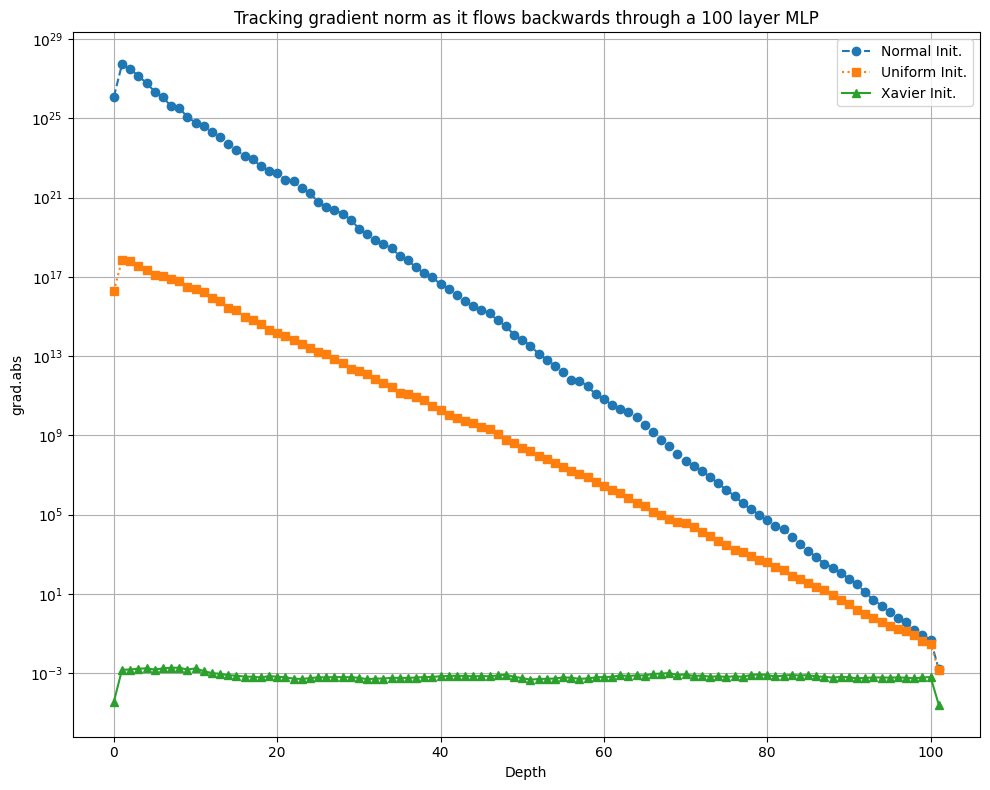

In [4]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

vocab_size = len(chars)  
model_dim = 64
model_depth = 100

def initialize_normal_model():
    embed = torch.randn(vocab_size, model_dim)  # N(0,1)
    hidden = torch.randn(model_depth, model_dim, model_dim)
    out = torch.randn(model_dim, vocab_size)

    return embed, hidden, out


def initialize_uniform_model():
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-1, 1)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-1, 1)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-1, 1)

    return embed, hidden, out

def initialize_xavier_model():
    k = np.sqrt(6.0 / (model_dim + model_dim)) 
    
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-k, k)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-k, k)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-k, k)

    return embed, hidden, out

def analyze_activation_statistics(init_method, X_batch, Y_batch):
    embed, hidden, out = init_method()

    params = [embed, hidden, out]
    for p in params:
        p.requires_grad_(True)

        if p.grad is not None:
            p.grad.zero_()

    # Forward pass
    X_embed = embed[X_batch]  
    
    hidden_act = torch.tanh(X_embed @ hidden[0]) 

    for layer in range(1, hidden.shape[0]):
        hidden_act = torch.tanh(hidden_act @ hidden[layer])

    out_logits = hidden_act @ out

    probs = F.softmax(out_logits, dim=-1)
    correct_logprobs = torch.log(probs[torch.arange(batch_size), Y_batch])
    loss = -correct_logprobs.mean()

    loss.backward()

    # Collecting the gradients
    grad_stats = [] 

    grad_stats.append(embed.grad.abs().mean().item())

    for layer in range(hidden.shape[0]):
        layer_grad = hidden.grad[layer] # Get the gradient for the k-th hidden matrix
        grad_stats.append(layer_grad.abs().mean().item())

    grad_stats.append(out.grad.abs().mean().item()) 

    return grad_stats

batch_size = 32
batch_idx = torch.randint(0, len(X), (batch_size,))
X_batch, Y_batch = X[batch_idx], Y[batch_idx]

normal_stats = analyze_activation_statistics(initialize_normal_model, X_batch, Y_batch)
uniform_stats = analyze_activation_statistics(initialize_uniform_model, X_batch, Y_batch)
xavier_stats = analyze_activation_statistics(initialize_xavier_model, X_batch, Y_batch)

plt.figure(figsize=(10, 8))
plt.plot(normal_stats, label="Normal Init.", marker='o', linestyle='--')
plt.plot(uniform_stats, label="Uniform Init.", marker='s', linestyle=':')
plt.plot(xavier_stats, label="Xavier Init.", marker='^', linestyle='-')
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('grad.abs')
plt.title(f'Tracking gradient norm as it flows backwards through a {model_depth} layer MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What we are witnessing here is an exponential explosion of gradient norm as the error propagates backwards through the layers. A perfect exponential (straight line on a log scale) that makes training completely unfeasible unless very low learning rates are used, and even then the problem gets worse and worse as you stack more and more layers and you have to tune the learning rate more and more carefully as you increase depth.

This is happening exponentially because when the gradients are computed via the chain rule the Jacobians of each layer are repeatedly multiplied:
$$
\frac{ \partial \mathcal{L} }{ \partial \mathbf{a}^{(\ell-1)} } = (W^{(\ell)})^\top \left[ \phi'(\mathbf{z})^{(\ell)} \cdot \frac{ \partial \mathcal{L} }{ \partial \mathbf{z}^{(\ell)} }  \right]
$$
Again, if $\text{Var}(W^{(\ell)})$ is not scaled to $1 / n^{(\ell)}$ then the gradient either explodes or vanishes depending on whether  $\text{Var}(W)\text{Var}(\phi') \gg 1 / n$ (exploding gradients, unstable learning) or $\text{Var}(W)\text{Var}(\phi') \ll 1 / n$ (vanishing gradients, nothing is learned as there's no error signal). As we can see in the plot we got the $\gg 1 / n$ case, our gradients explode exponentially unless we used the appropriate Glorot initialization for `tanh`, which makes our network depth independent, allowing us to scale the depth of the model seamlessly without having to rethink our learning rate and training regimen and constantly worrying about stability.

### Validating the theory during training

We will train a 5 layer MLP to validate training stability and learning rate conjectures

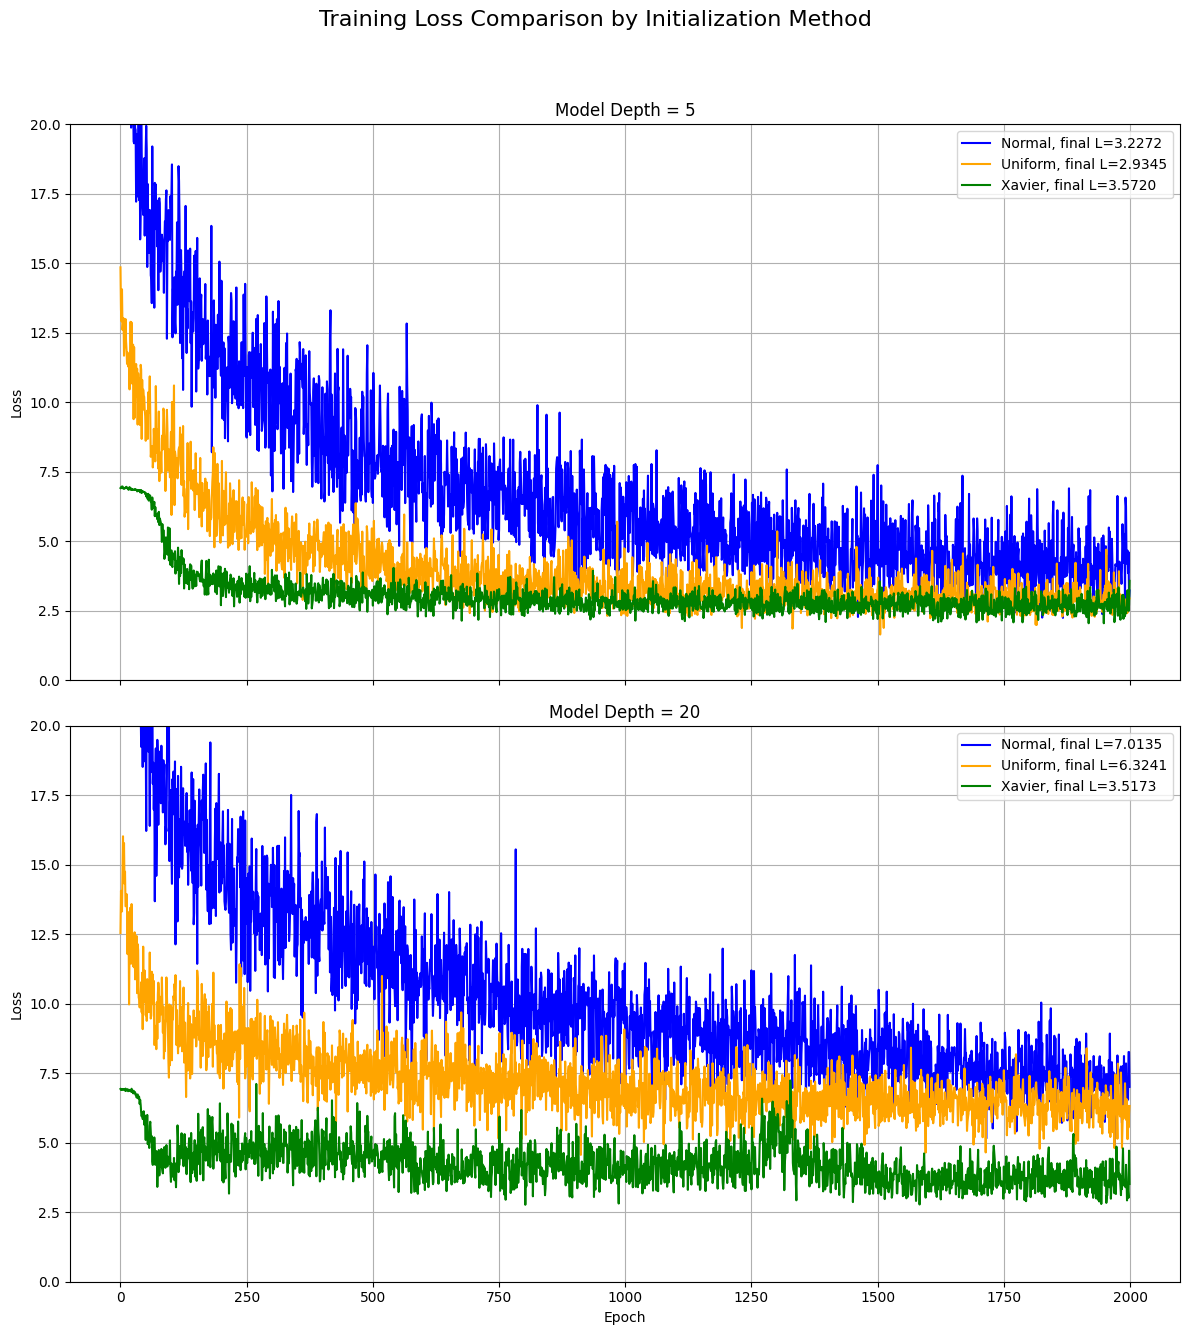

In [37]:
def train_with_initialization(init_method, num_epochs=2000, learning_rate=0.05, batch_size=32):
    # Initialize parameters with gradients
    embed, hidden, out = init_method()
    embed.requires_grad_(True)
    hidden.requires_grad_(True)
    out.requires_grad_(True)
    
    # Optimizer
    parameters = [embed, hidden, out]
    optimizer = torch.optim.SGD(parameters, lr=learning_rate)
    
    # Training loop
    losses = []
    for epoch in range(num_epochs):
        batch_idx = torch.randint(0, len(X), (batch_size,))
        X_batch = X[batch_idx]
        Y_batch = Y[batch_idx]
        
        # Forward pass
        X_embed = embed[X_batch]
        hidden_act = torch.tanh(X_embed @ hidden[0]) 

        for layer in range(1, hidden.shape[0]):
            hidden_act = torch.tanh(hidden_act @ hidden[layer])

        out_logits = hidden_act @ out
        # Calculate loss
        loss = F.cross_entropy(out_logits, Y_batch)
        losses.append(loss.item())
         
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

num_epochs = 2000 
learning_rate = 0.05 
batch_size = 32
model_dim = 64 

# Define the depths to compare
depth_5 = 5
depth_20 = 20

model_depth = depth_5 

normal_losses_d5 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d5 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d5 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


model_depth = depth_20

normal_losses_d20 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d20 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d20 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

ax[0].plot(normal_losses_d5, label=f'Normal, final L={normal_losses_d5[-1]:.4f}', color='blue')
ax[0].plot(uniform_losses_d5, label=f'Uniform, final L={uniform_losses_d5[-1]:.4f}', color='orange')
ax[0].plot(xavier_losses_d5, label=f'Xavier, final L={xavier_losses_d5[-1]:.4f}', color='green')
ax[0].set_title(f'Model Depth = {depth_5}')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 20) 
ax[0].legend()
ax[0].grid(True)

ax[1].plot(normal_losses_d20, label=f'Normal, final L={normal_losses_d20[-1]:.4f}', color='blue')
ax[1].plot(uniform_losses_d20, label=f'Uniform, final L={uniform_losses_d20[-1]:.4f}', color='orange')
ax[1].plot(xavier_losses_d20, label=f'Xavier, final L={xavier_losses_d20[-1]:.4f}', color='green')
ax[1].set_title(f'Model Depth = {depth_20}')
ax[1].set_xlabel('Epoch') # X-label only on the bottom plot due to sharex=True
ax[1].set_ylabel('Loss' )
ax[1].set_ylim(0, 20) 
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Training Loss Comparison by Initialization Method', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()


As we can see, with a shallow network of depth $5$ we can get pretty good results from every initialization type, Xavier *does* converge faster in this case which is a benefit, it has the lowest starting loss and quickly reaches a good stopping point after $1000$ epochs or so. With a network so shallow result vary, if we run this many more times we'll see that a model with Xavier initializations ends up with a lower loss about half of the times compared to one with uniform initializations. Normal initializations models tend to loose hard every time as their layer by layer variane is the highest and therefore they are way more affected by the problems we've been trying to mitigate from the get go.

The story changes when we train a deeper network of depth $20$, here Xavier models are the undisputet kings, achieving not only a much lower final loss every time but a more stable loss curve overall. Devil's in the details though, we already described a bunch of theory to explain why randomly chosen initializations like Normal and Uniform would pretty quickly run into training stability issues as model depth increased, but we can see that the Xavier curve is not exactly a straight line either, there are points where loss starts to diverge before catching itself and going back down, if we run this experiment many times we'll face a very diverse set of loss curves, from very well behaving and down to earth like at depth $5$, to straight up maniaical, where the loss seems fine for a while before making a big, sudden jump and then fighting to readjust. 

**NOTE**: These results are exacerbated by the fact that our optimizer is way too agressive (high lr, low batch size), causing massive loss spikes and stability issues. This is okay for illustrative purposes but a better way to work with what we have is to halve the learning rate and increase the batch size quite a bit. There are formal reasons on *why* exactly this is done and why it improves everything about our results, but my intuition for now is that our learning rate is too high (lets say we deduced that experimentally just from seeing the spikes in the loss curves) and that our dataset is way too noisy with a batch size of 32, a batch of 32 images and a label carries a lot of information for the optimizer to get a high quality approzimation of the gradient, 32 characters and their next characters not so much, it's too noisy and low signal. Increasing the batch size by a lot fixes this, giving us a way smoother loss curves and letting Xavier reach a very similar loss at depths $5$ and $20$, this doesn't mean the problem described above is not there, it just means it's less visible.

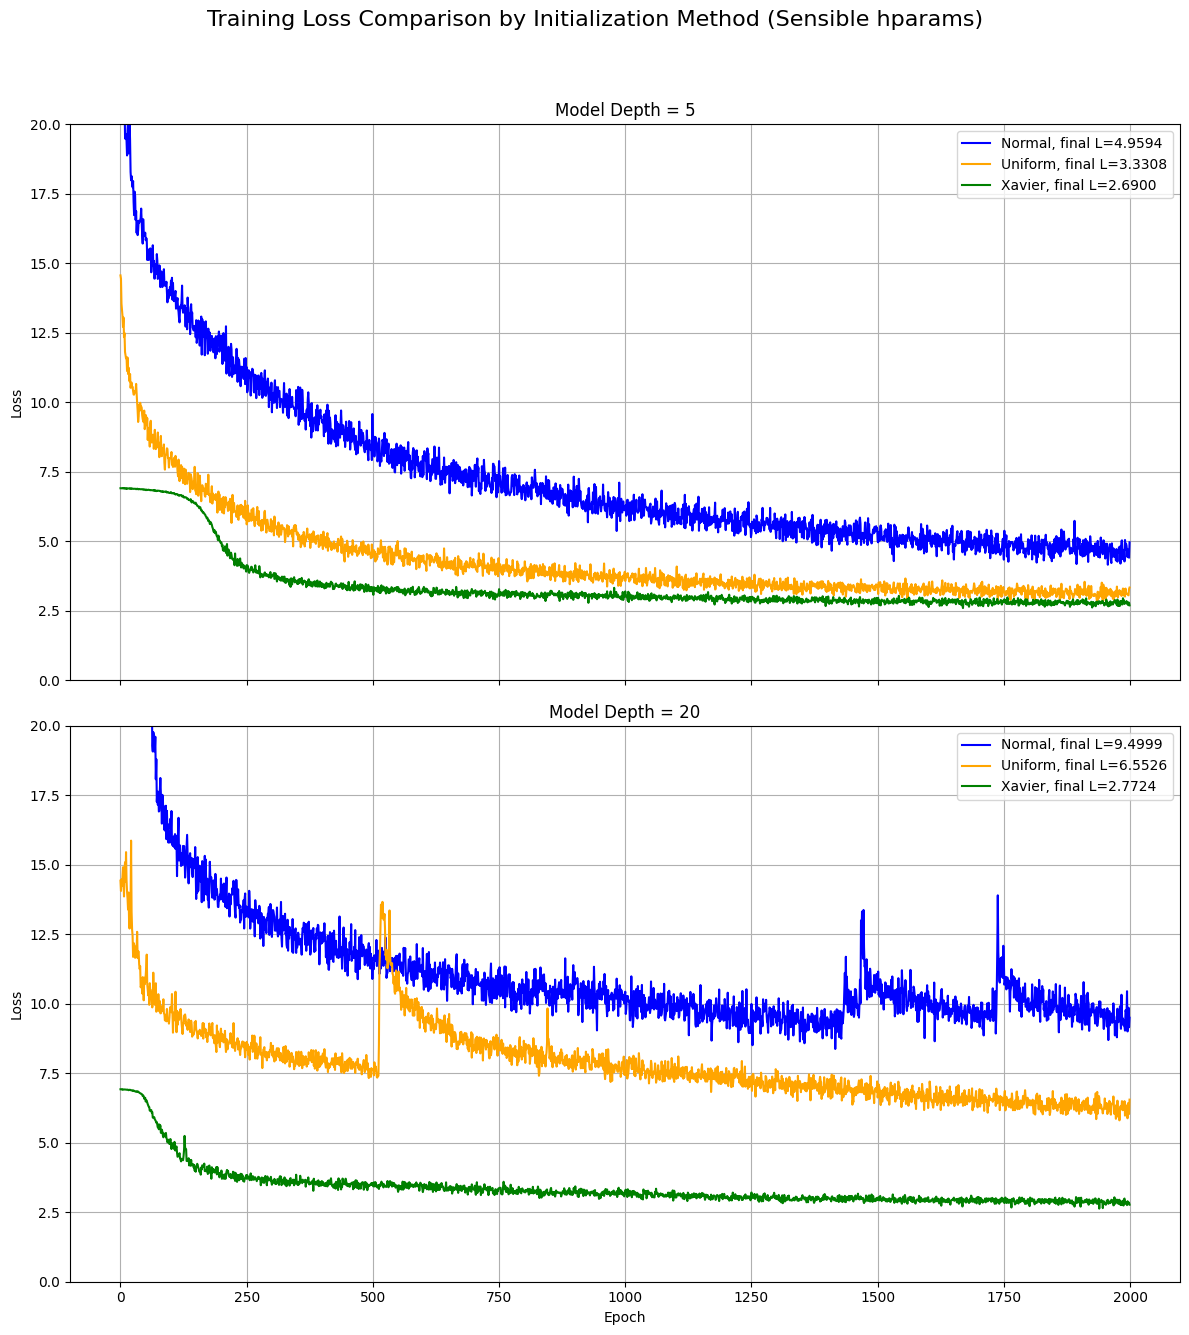

In [41]:
num_epochs = 2000 
learning_rate = 0.025 
batch_size = 512
model_dim = 64 

# Define the depths to compare
depth_5 = 5
depth_20 = 20

model_depth = depth_5 

normal_losses_d5 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d5 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d5 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


model_depth = depth_20

normal_losses_d20 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d20 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d20 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

ax[0].plot(normal_losses_d5, label=f'Normal, final L={normal_losses_d5[-1]:.4f}', color='blue')
ax[0].plot(uniform_losses_d5, label=f'Uniform, final L={uniform_losses_d5[-1]:.4f}', color='orange')
ax[0].plot(xavier_losses_d5, label=f'Xavier, final L={xavier_losses_d5[-1]:.4f}', color='green')
ax[0].set_title(f'Model Depth = {depth_5}')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 20) 
ax[0].legend()
ax[0].grid(True)

ax[1].plot(normal_losses_d20, label=f'Normal, final L={normal_losses_d20[-1]:.4f}', color='blue')
ax[1].plot(uniform_losses_d20, label=f'Uniform, final L={uniform_losses_d20[-1]:.4f}', color='orange')
ax[1].plot(xavier_losses_d20, label=f'Xavier, final L={xavier_losses_d20[-1]:.4f}', color='green')
ax[1].set_title(f'Model Depth = {depth_20}')
ax[1].set_xlabel('Epoch') # X-label only on the bottom plot due to sharex=True
ax[1].set_ylabel('Loss' )
ax[1].set_ylim(0, 20) 
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Training Loss Comparison by Initialization Method (Sensible hparams)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()



### Not the full picture

While smart parameter initializations give us a very good head start in training stability and reliability they **do NOT** guarantee that such properties will be preserved as training progresses. Training the model of course changes it's parameters and we should not assume that we have any reason to expect that all those nice statistical properties we initialized them with will stay as they are when the model starts to fit our data, which may (and often does) end up causing the same issues that we were trying to solve here (dead neurons, unstable training), we've just kicked it further down the line.